# Click-Through Rate Prediction
## Random Forest / XGBoost

Ryan Koch, Sam Kahr, Julia Kang - AMLI 2019

References: https://towardsdatascience.com/mobile-ads-click-through-rate-ctr-prediction-44fdac40c6ff

## Import Libraries and Data

In [6]:
import pandas as pd
import numpy as np
import multiprocessing as mp
import psutil
import random
import datetime as datetime
import matplotlib.pyplot as plt

In [7]:
# read in the Avazu - criteo labs - csv file
# rand_sample_csv is a randomized subset (1% the size) of the sample_csv which is ~400k instances 

df = pd.read_csv('/home/data/rand_sample_csv.csv')


# Data Exploration

In [8]:
df.head(5)

,Unnamed: 0,Unnamed: 0.1,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,0,236,13120299559997056165,0,14102100,1005,0,543a539e,c7ca3108,3e814130,...,1,0,20362,320,50,2333,0,39,-1,157
1,1,259,13447361190641805430,0,14102100,1005,1,17caea14,0dde25ec,f028772b,...,1,0,19950,320,50,1800,3,167,100075,23
2,2,357,14758321504714974000,0,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,...,1,0,19743,320,50,2264,3,427,100000,61
3,3,455,16246356889796608406,0,14102100,1005,0,5b08c53b,7687a86e,3e814130,...,1,0,17654,300,250,1994,2,39,100084,33
4,4,540,17569568361412548369,0,14102100,1005,0,543a539e,c7ca3108,3e814130,...,1,0,20362,320,50,2333,0,39,-1,157


In [9]:
df.describe()

,Unnamed: 0,Unnamed: 0.1,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,4184.000000,4184.000000,4.184000e+03,4184.000000,4.184000e+03,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000
mean,2091.500000,202351.664675,9.113168e+18,0.170172,1.410256e+07,1004.977533,0.283222,1.012189,0.331501,18728.379302,318.803059,60.868069,2100.065488,1.412285,229.095841,53381.884082,84.231836
std,1207.961092,116384.632429,5.389524e+18,0.375829,2.963423e+02,1.032567,0.489278,0.488054,0.856303,5058.361185,22.743031,48.729395,621.145767,1.324642,358.883751,49952.289351,70.673532
min,0.000000,236.000000,1.513211e+15,0.000000,1.410210e+07,1002.000000,0.000000,0.000000,0.000000,375.000000,216.000000,36.000000,112.000000,0.000000,33.000000,-1.000000,13.000000
25%,1045.750000,99768.500000,4.449284e+18,0.000000,1.410230e+07,1005.000000,0.000000,1.000000,0.000000,16687.000000,320.000000,50.000000,1800.000000,0.000000,35.000000,-1.000000,23.000000
50%,2091.500000,204607.500000,9.042769e+18,0.000000,1.410260e+07,1005.000000,0.000000,1.000000,0.000000,20312.000000,320.000000,50.000000,2314.000000,2.000000,39.000000,100053.500000,61.000000
75%,3137.250000,301481.250000,1.381808e+19,0.000000,1.410281e+07,1005.000000,1.000000,1.000000,0.000000,21893.000000,320.000000,50.000000,2526.000000,3.000000,169.000000,100084.750000,111.000000
max,4183.000000,404396.000000,1.844673e+19,1.000000,1.410302e+07,1012.000000,7.000000,5.000000,5.000000,24041.000000,728.000000,480.000000,2756.000000,3.000000,1839.000000,100248.000000,255.000000


In [10]:
# looks like clicks were normalized to 1. 
# What is 0.17 of a click, likely the probability of a click. 0 no click, 1 click

In [11]:
df.shape # this sample has 4,184 rows of data with 26 columns

(4184, 26)

In [12]:
df.dtypes
# avazu: "all integer features are categorical variables, all IDs, no numerical meaning"

Unnamed: 0           int64
Unnamed: 0.1         int64
id                  uint64
click                int64
hour                 int64
C1                   int64
banner_pos           int64
site_id             object
site_domain         object
site_category       object
app_id              object
app_domain          object
app_category        object
device_id           object
device_ip           object
device_model        object
device_type          int64
device_conn_type     int64
C14                  int64
C15                  int64
C16                  int64
C17                  int64
C18                  int64
C19                  int64
C20                  int64
C21                  int64
dtype: object

In [13]:
# what do the columns mean?

 - id: ad identifier
 - click: 0/1 for non-click/click
 - hour: format is YYMMDDHH
 - C1 — anonymized categorical variable
 - banner_pos
 - site_id
 - site_domain
 - site_category
 - app_id
 - app_domain
 - app_category
 - device_id
 - device_ip
 - device_model
 - device_type
 - device_conn_type
 - C14-C21 — anonymized categorical variables

In [14]:
# what are the range of unique values of each column
for col in df.columns.values:
    print( "{}".format(len(df[col].unique())))

4184
4184
4184
2
240
5
5
354
292
14
244
32
14
660
3908
871
4
4
675
4
5
279
4
59
105
54


In [15]:
# lets look at an individual user

df[df.id == 13447361190641805430]

,Unnamed: 0,Unnamed: 0.1,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
1,1,259,13447361190641805430,0,14102100,1005,1,17caea14,0dde25ec,f028772b,...,1,0,19950,320,50,1800,3,167,100075,23


# Questions of the data

In [16]:
# At which time do people click ads most frequently?
# where are most clicks coming from? 
# what nique correlations from any or all combinations of each column relate to click?
# what correlations between seemingly unrelated columns (banner_pos and device type, etc.) exist?
# how are banner_pos, device_type, device_conn_type encoded?

# Data Preprocessing

In [17]:
#  unnamed column are columns that are created when a dataframe is converted to a csv. 
# 'Unnamed: 0', 'Unnamed: 0.1' are row indexes which were tansposed into columns.
df_new = df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1) 

In [18]:
df_new.shape

(4184, 24)

In [19]:
# how many unique values are in each col?

for col in df_new.columns.values:
    print(str(col)+ ": " +  "{}".format(len(df_new[col].unique())) )
    

id: 4184
click: 2
hour: 240
C1: 5
banner_pos: 5
site_id: 354
site_domain: 292
site_category: 14
app_id: 244
app_domain: 32
app_category: 14
device_id: 660
device_ip: 3908
device_model: 871
device_type: 4
device_conn_type: 4
C14: 675
C15: 4
C16: 5
C17: 279
C18: 4
C19: 59
C20: 105
C21: 54


In [20]:
# check for missing values

df_new.isnull().sum()


id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64

In [21]:
# summed list of each column for df_new, looking for inconsistencies

for col in df_new.columns.values:
    total = len(df_new[col].unique())
    print(str(col) + " " + "total: " + str(total))

id total: 4184
click total: 2
hour total: 240
C1 total: 5
banner_pos total: 5
site_id total: 354
site_domain total: 292
site_category total: 14
app_id total: 244
app_domain total: 32
app_category total: 14
device_id total: 660
device_ip total: 3908
device_model total: 871
device_type total: 4
device_conn_type total: 4
C14 total: 675
C15 total: 4
C16 total: 5
C17 total: 279
C18 total: 4
C19 total: 59
C20 total: 105
C21 total: 54


In [22]:
# tried writing an algo to check for erroneous, inconsistent spelling or abbreviations, formatting issues (e.g., odd/unexpected characters or punctuation)
# couldn't work one out... moving on

Each instance of a column are hashed values of an original ID.
Hashing was done to anonymize the services contributing ad data to this dataset.
For illustrative/descriptive purposes we will treat each hashed value as names or in other fictional contexts (e.g.,'7801e8d9' = 'www.overstock.com'). (Thank you Naomi!)

# Feature Engineering
## Hour & Date 

In [23]:
# check hour column data type
df_new.hour.dtype

dtype('int64')

In [24]:
# separate the date and time
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')
df_new['new_hour'] = df_new.hour.astype(str).apply(parse_date)
df_new['new_hour']

0      2014-10-21 00:00:00
1      2014-10-21 00:00:00
2      2014-10-21 00:00:00
3      2014-10-21 00:00:00
4      2014-10-21 00:00:00
5      2014-10-21 00:00:00
6      2014-10-21 00:00:00
7      2014-10-21 00:00:00
8      2014-10-21 00:00:00
9      2014-10-21 00:00:00
10     2014-10-21 00:00:00
11     2014-10-21 01:00:00
12     2014-10-21 01:00:00
13     2014-10-21 01:00:00
14     2014-10-21 01:00:00
15     2014-10-21 01:00:00
16     2014-10-21 01:00:00
17     2014-10-21 01:00:00
18     2014-10-21 01:00:00
19     2014-10-21 01:00:00
20     2014-10-21 01:00:00
21     2014-10-21 01:00:00
22     2014-10-21 01:00:00
23     2014-10-21 01:00:00
24     2014-10-21 01:00:00
25     2014-10-21 01:00:00
26     2014-10-21 01:00:00
27     2014-10-21 01:00:00
28     2014-10-21 01:00:00
29     2014-10-21 01:00:00
               ...        
4154   2014-10-30 20:00:00
4155   2014-10-30 20:00:00
4156   2014-10-30 21:00:00
4157   2014-10-30 21:00:00
4158   2014-10-30 21:00:00
4159   2014-10-30 21:00:00
4

In [25]:
# check if column 'new_hour' was created and parsed to string
df_new.head(3)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,new_hour
0,13120299559997056165,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,0,20362,320,50,2333,0,39,-1,157,2014-10-21
1,13447361190641805430,0,14102100,1005,1,17caea14,0dde25ec,f028772b,ecad2386,7801e8d9,...,0,19950,320,50,1800,3,167,100075,23,2014-10-21
2,14758321504714974000,0,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,...,0,19743,320,50,2264,3,427,100000,61,2014-10-21


In [26]:
#confirm dtype of new_hour
df_new.new_hour.dtype

dtype('<M8[ns]')

In [27]:
# create new_date & new_time columns from parsed new_hour column
df_new['date'] = [d.date() for d in df_new['new_hour']]
df_new['time'] = [d.time() for d in df_new['new_hour']]

In [28]:
#check if columns were established properly
df_new.head(3)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C15,C16,C17,C18,C19,C20,C21,new_hour,date,time
0,13120299559997056165,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,320,50,2333,0,39,-1,157,2014-10-21,2014-10-21,00:00:00
1,13447361190641805430,0,14102100,1005,1,17caea14,0dde25ec,f028772b,ecad2386,7801e8d9,...,320,50,1800,3,167,100075,23,2014-10-21,2014-10-21,00:00:00
2,14758321504714974000,0,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,...,320,50,2264,3,427,100000,61,2014-10-21,2014-10-21,00:00:00


In [29]:
df_new.dtypes

id                          uint64
click                        int64
hour                         int64
C1                           int64
banner_pos                   int64
site_id                     object
site_domain                 object
site_category               object
app_id                      object
app_domain                  object
app_category                object
device_id                   object
device_ip                   object
device_model                object
device_type                  int64
device_conn_type             int64
C14                          int64
C15                          int64
C16                          int64
C17                          int64
C18                          int64
C19                          int64
C20                          int64
C21                          int64
new_hour            datetime64[ns]
date                        object
time                        object
dtype: object

In [30]:
# drop redundant cols
df_tmp = df_new.drop(['new_hour', 'hour'], axis=1)

In [31]:
df_tmp.head(2)

,id,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,C14,C15,C16,C17,C18,C19,C20,C21,date,time
0,13120299559997056165,0,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,...,20362,320,50,2333,0,39,-1,157,2014-10-21,00:00:00
1,13447361190641805430,0,1005,1,17caea14,0dde25ec,f028772b,ecad2386,7801e8d9,07d7df22,...,19950,320,50,1800,3,167,100075,23,2014-10-21,00:00:00


In [32]:
df_tmp.head(2)

,id,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,C14,C15,C16,C17,C18,C19,C20,C21,date,time
0,13120299559997056165,0,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,...,20362,320,50,2333,0,39,-1,157,2014-10-21,00:00:00
1,13447361190641805430,0,1005,1,17caea14,0dde25ec,f028772b,ecad2386,7801e8d9,07d7df22,...,19950,320,50,1800,3,167,100075,23,2014-10-21,00:00:00


In [33]:
# sannity check of summed columns for unique vals

for col in df_tmp.columns.values:
    total = len(df_tmp[col].unique())
    print(str(col) + " " + "total: " + str(total))

id total: 4184
click total: 2
C1 total: 5
banner_pos total: 5
site_id total: 354
site_domain total: 292
site_category total: 14
app_id total: 244
app_domain total: 32
app_category total: 14
device_id total: 660
device_ip total: 3908
device_model total: 871
device_type total: 4
device_conn_type total: 4
C14 total: 675
C15 total: 4
C16 total: 5
C17 total: 279
C18 total: 4
C19 total: 59
C20 total: 105
C21 total: 54
date total: 10
time total: 24


In [34]:
# save to csv to back up work
df_new.to_csv("rf_date_time_sample.csv")

# Features

 - Target feature : click
 - Site features : site_id, site_domain, site_category
 - App feature: app_id, app_domain, app_category
 - Device feature: device_id, device_ip, device_model, device_type, device_conn_type
 - Anonymized categorical features: C14-C21

# Clicks

In [35]:
#see what percentage of people click and what percentage of people do not click
# click = 17%, no click = 83%
df_tmp['click'].value_counts()/4184

0    0.829828
1    0.170172
Name: click, dtype: float64

In [36]:
#Find the start and end date of the dataset
print(df_tmp['date'].min(), df_tmp['date'].max())

2014-10-21 2014-10-30


Our dataset ranges from 10/21/2014 to 10/30/2014. It spans a total of 10 days.

# Data Visualization

### Click viz
0 = no click, 1 = click

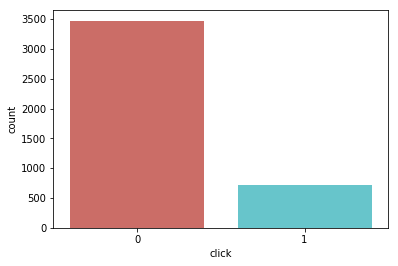

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='click',data=df_tmp, palette='hls')
plt.show();

Text(0.5, 1.0, 'Clicks by Date')

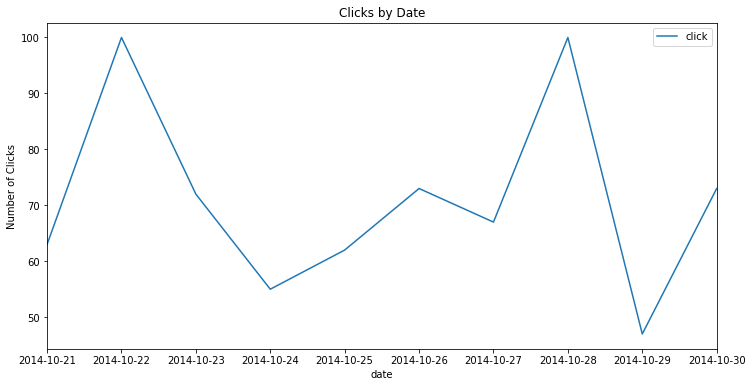

In [38]:
# make groups of summed clicks by date
df_tmp.groupby(['date']).agg({'click': 'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of Clicks')
plt.title('Clicks by Date')


High click rate on Oct. 22nd and OCt. 28
Low click rate on Oct. 24 with lowest rate on Oct. 29

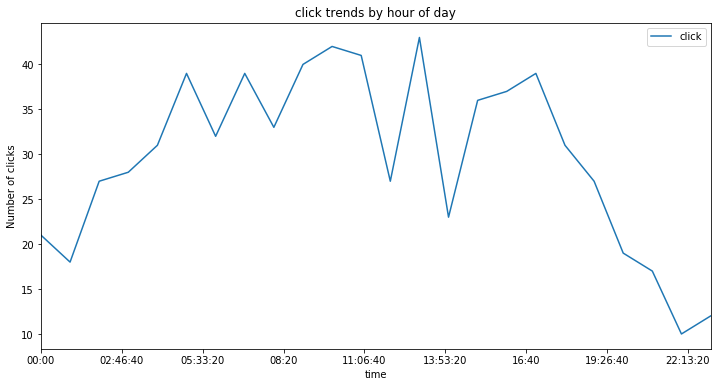

In [39]:
df_tmp.groupby('time').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('click trends by hour of day');

Highest number of clicks is around 2pm wit